## Step 0: Setup

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg  # for image load and processing
import pandas as pd

from sklearn.cluster import KMeans


## Step 1: Load image

In [3]:
img = mpimg.imread("charmainder.png")  # replace this path with the image path

<b>imread</b> : it loads an image file into a Numpy array 
* <b>Return shape</b>:
  * Color RGB : (height, width, 3)
  * RGBA (has transparency alpha) : (H, W, 4)
  * Gray scale: (Height, Width)
 
* <b>Dtype & range (important)</b>:
  * Often PNG -> `float32` in [0, 1] range
  * Often JPG -> `uint8` in [0, 255] range
  * (This behavior can vary slightly by image/matplotlib version, so always check)

* <b>Color order: </b> RGB (good for Matplotlib plots)
* <b>No flags</b> (unlike OpenCV). It auto detects mode (RGB/RGBA/gray).

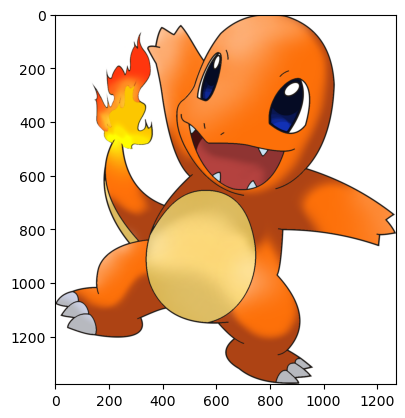

In [59]:
plt.imshow(img)

### preprocessing

In [4]:
# checking the image
type(img)

numpy.ndarray

In [5]:
img

array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       ...,

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]], dtype=float32)

In [7]:
img.shape

(1378, 1269, 3)

1378 rows, height \
1269 columns, width \
3 channels , rgb, depth 

In [8]:
img.dtype

dtype('float32')

In [58]:
print("RAW : "), 
print("img dtype : ", img.dtype)
print(f"img array value range : {img.min()} to {img.max()}")
print("img shape : ", img.shape)

RAW : 
img dtype :  float32
img array value range : 0.0 to 1.0
img shape :  (1378, 1269, 3)


In [11]:
img.ndim

3

In [12]:
img.shape[-1]  # checking if there is alpha channel as we

3

### Normalizing the uploaded image and converting into dtype(float32), if it's not

In [17]:
# Normalize to [0,1] floats
if img.dtype == np.uint8:
    # np.unit8 is Numpy's unsigned 8-bit integer type
    # Range : 0 to 255
    # size : 1 byte per element
    # since we need calculations in float we will convert the image np.array to float
    img = img.astype(np.float32) / 255.0
else:
    img = img.astype(np.float32)
    if img.max() > 1.0:  # note: it is rare to have float32 and max val greater than 1.0, but just in case
        img = img / 255.0

### Handling alpha / grayscale images

In [18]:
# Dropping alpha if present
if img.ndim == 3 and img.shape[-1] > 3:
    # checking if the no. of channels = 4
    img = img[..., :3] 

* in numpy `...` (ellipsis) = means keep all preceding dimensions unchanged
* `: 3` = on the **last axis** (i.e for the channels) selects indices `0, 1, 2` (the first three channels).

So for images:
* if img.shape is **(H, W, 4)** (RGBA),=> this drops alpha and becomes **(H, W, 3)** (RGB)
* if img.shape is **(H, W, 3)** (already RGB),=> it stays **(H, W, 3)** (no change)
* if img.shape is **(H, W)** (grayscale, no channel axis), this will through error (bcoz no last-axis channels to slice).

In [19]:
# Prompting grayscale to 3 channels
if img.ndim == 2:
    img = np.stack( [img, img, img], axis= -1 )

<b> What it does </b> 

* it makes 3 copies of the same 2D array and stacks them along a new last axis
* Resulting shape : from (H, W) to **(H, W, 3)**
* Each of RGB channels gets the same grayscale values, so the picture looks identical- just now it's in RGB form

<b> Why do this? </b> 
Many pipelines (like KMeans) expect a 3-channel image, this normalizes the shape


### Pre-Processed image 

In [20]:
print("After : ", img.dtype, img.min(), img.max(), img.shape)

After :  float32 0.0 1.0 (1378, 1269, 3)


## Step - 02: Flatten image for K Means
right now it's in 3D, (three 2D matrices) \
from (H, W, 3) => (H*W, 3)

In [23]:
H, W, C = img.shape
print(f"H = {H}, W = {W}, C = {C}")

H = 1378, W = 1269, C = 3


In [24]:
X = img.reshape(-1, 3)

* it means "figure out the right number of rows automically, keeping 3 columns)
* So if image is **(H, W, 3)**, it would convert to **(H*W, 3)**

In [25]:
print("X.shape = ", X.shape)

X.shape =  (1748682, 3)


In [27]:
print("X dtype : ", X.shape)
print(f"X range : {X.min()} to {X.max()}" )

X dtype :  (1748682, 3)
X range : 0.0 to 1.0


In [30]:
print(X[:5, :]) # visualizing the first 5 columns

[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]


## Step 3 : fit the k means algo

In [31]:
k = int(input("Enter k (less the k, higher the compression) : " ))

Enter k (less the k, higher the compression) :  4


In [33]:
kmeans = KMeans(
    n_clusters = k,
    random_state = 11,
    n_init = 10)

In [35]:
kmeans.fit(X)

KMeans(n_clusters=4, n_init=10, random_state=11)

In [46]:
labels = kmeans.labels_
print(labels.shape)
print(set(labels))
print(labels)

(1748682,)
{0, 1, 2, 3}
[0 0 0 ... 0 0 0]


In [49]:
centroids = kmeans.cluster_centers_
print(centroids.shape, "=(no. of cluster, 3)")

cent_df = pd.DataFrame(centroids)
cent_df.head()

(4, 3) =(no. of cluster, 3)


,0,1,2
0,0.997837,0.997794,0.998679
1,0.856118,0.377923,0.093220
2,0.113519,0.102443,0.135509
3,0.941937,0.733809,0.379746


In [41]:
inertia = kmeans.inertia_
print("Inertia = ", inertia)

Inertia =  33742.3515625


## Step 4 : Rebuild the image to compressed

In [47]:
# Replace each pixel by its centroid color
compressed = centroids[labels]
print(compressed.shape)

(1748682, 3)


In [50]:
compressed = compressed.reshape(H, W, 3)
print(compressed.shape)

(1378, 1269, 3)


## Step 5: Displaying before / after compression

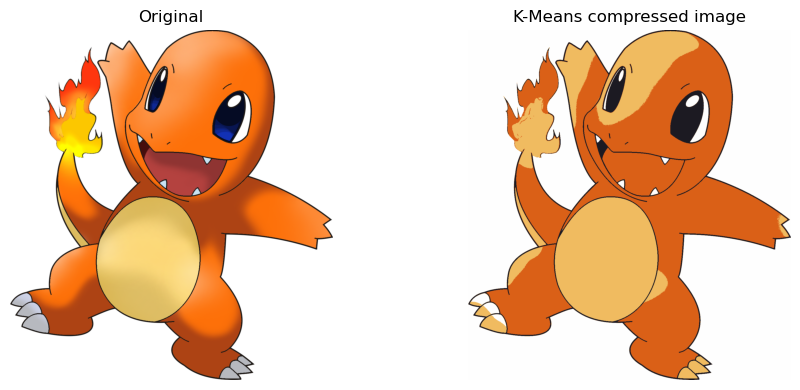

In [54]:
plt.figure(figsize = (10, 4))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original")
plt.axis("off") # - plt.axis('off'): Removes the x and y axes so the image appears without any borders or tick marks.

plt.subplot(1, 2, 2)
plt.imshow( np.clip(compressed, 0, 1))  # see the markdown below for explaination
plt.title(f"K-Means compressed image")
plt.axis("off")

plt.tight_layout()
plt.show()


`np.clip(compressed, 0, 1)` means : **keep every value in `compressed` within the range [0, 1].**

* Any value < **0** becomes **0** (black)
* Any value > **1** becomes **1** (full intensity).
* Values already between 0 and 1 are unchanged.

<b>Why here?</b>
* Our image array is float RGB in [0, 1]
* Matplotlib expects that range for float images. clipping is a safety net in case tiny numerical steps push a few values slightly below 0 or above 1 (which could cause warnings or errors)

### save the compressed image

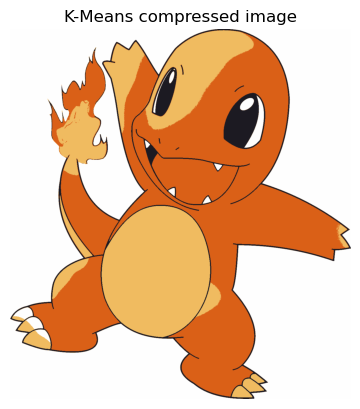

In [55]:
plt.imshow( np.clip(compressed, 0, 1))  # see the markdown below for explaination
plt.title(f"K-Means compressed image")
plt.axis("off")
plt.savefig("compressed-charmainder.png")

In [63]:
# mpimg.imsave("compressed-trial.png", np.clip(compressed, 0, 1))